In [1]:
%time
import os
import sys
import time
import random
import string
from ast import literal_eval
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import numpy as np
import pandas as pd
import sklearn

# libraries for text cleaning
import contractions
from bs4 import BeautifulSoup
from textblob import TextBlob
from spellchecker import SpellChecker
#from profanity_check import predict

#for oversampling
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# libraries and packages for text (pre-)processing 
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')


from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import *
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk import pos_tag_sents
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TweetTokenizer

##libraries and packages for EDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

Wall time: 0 ns


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vanes\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vanes\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vanes\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
train_df = pd.read_csv("Data/train.csv")
print(train_df.shape)
train_df.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


<a id="featureengineering"></a>
# 4. Feature Engineering

## Word Embedding

There are some decisions we need to make:
- should stop words and punctuations be removed before embedding
- custom embeddings or pre-trained embeddings or embedding layer
- for pre-trained embeddings, which package to use: Word2Vec/GloVe, FastText, BERT
- the size of vector to represent each text
- word embedding or sentence embedding

In [79]:
# for word embeddings
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec

# for BERT
import torch
from transformers import BertTokenizer, BertModel

In [82]:
# define a helper function to calculate the embedding vector of each text
def get_embeddings(vectors, text, generate_missing=False, k=25):
    # dealing with empty text
    if len(text)<1:
        return np.zeros(k)
    # generate randomized vectors for unseen words if generate_missing is True
    if generate_missing:
        vectorized = [vectors[word][:k] if word in vectors else np.random.rand(k) for word in text]
    # represent unseen words with 0 vector if generate_missing is False
    else:
        vectorized = [vectors[word][:k] if word in vectors else np.zeros(k) for word in text]
    # each text is represented by averaging the vectors of its constituent words
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

### Global Vectors for Word Representation (GloVe)

Similar to Word2Vec method, each word is presented by a high dimension vector and trained based on the surrounding words over a huge corpus. Since our project works on Tweets, we apply a pre-trained word embedding trained over Twitter content (https://github.com/stanfordnlp/GloVe).

Advantages:
- It captures the position of the words in the text (syntactic)
- It captures meaning in the words (semantics)

Limitations:
- It cannot capture the meaning of the word from the text (fails to capture polysemy)
- It cannot capture out-of-vocabulary words from corpus

In [ ]:
# generate a word2vec file used for model building - 25d
glove_input_file = "D:/GoogleDownloads/BT4222/glove.twitter.27B/glove.twitter.27B.25d.txt"
word2vec_output_file = "glove.twitter.27B.25d.txt.word2vec"
glove2word2vec(glove_input_file, word2vec_output_file)

In [80]:
# generate a word2vec file used for model building - 200d
glove_input_file = "D:/GoogleDownloads/BT4222/glove.twitter.27B/glove.twitter.27B.200d.txt"
word2vec_output_file = "glove.twitter.27B.200d.txt.word2vec"
glove2word2vec(glove_input_file, word2vec_output_file)

(1193517, 200)

In [87]:
# build a GloVe model
glove_model = gensim.models.KeyedVectors.load_word2vec_format("glove.twitter.27B.200d.txt.word2vec", binary=False, limit=1190000) 

In [88]:
# generate embedding vectors of size 25 using tokenized text (stop words and punctuation kept)
# side note: map function outperforms for loop
embeddings_glove = processed_df["text_tokenized"].map(lambda x: get_embeddings(glove_model, x))

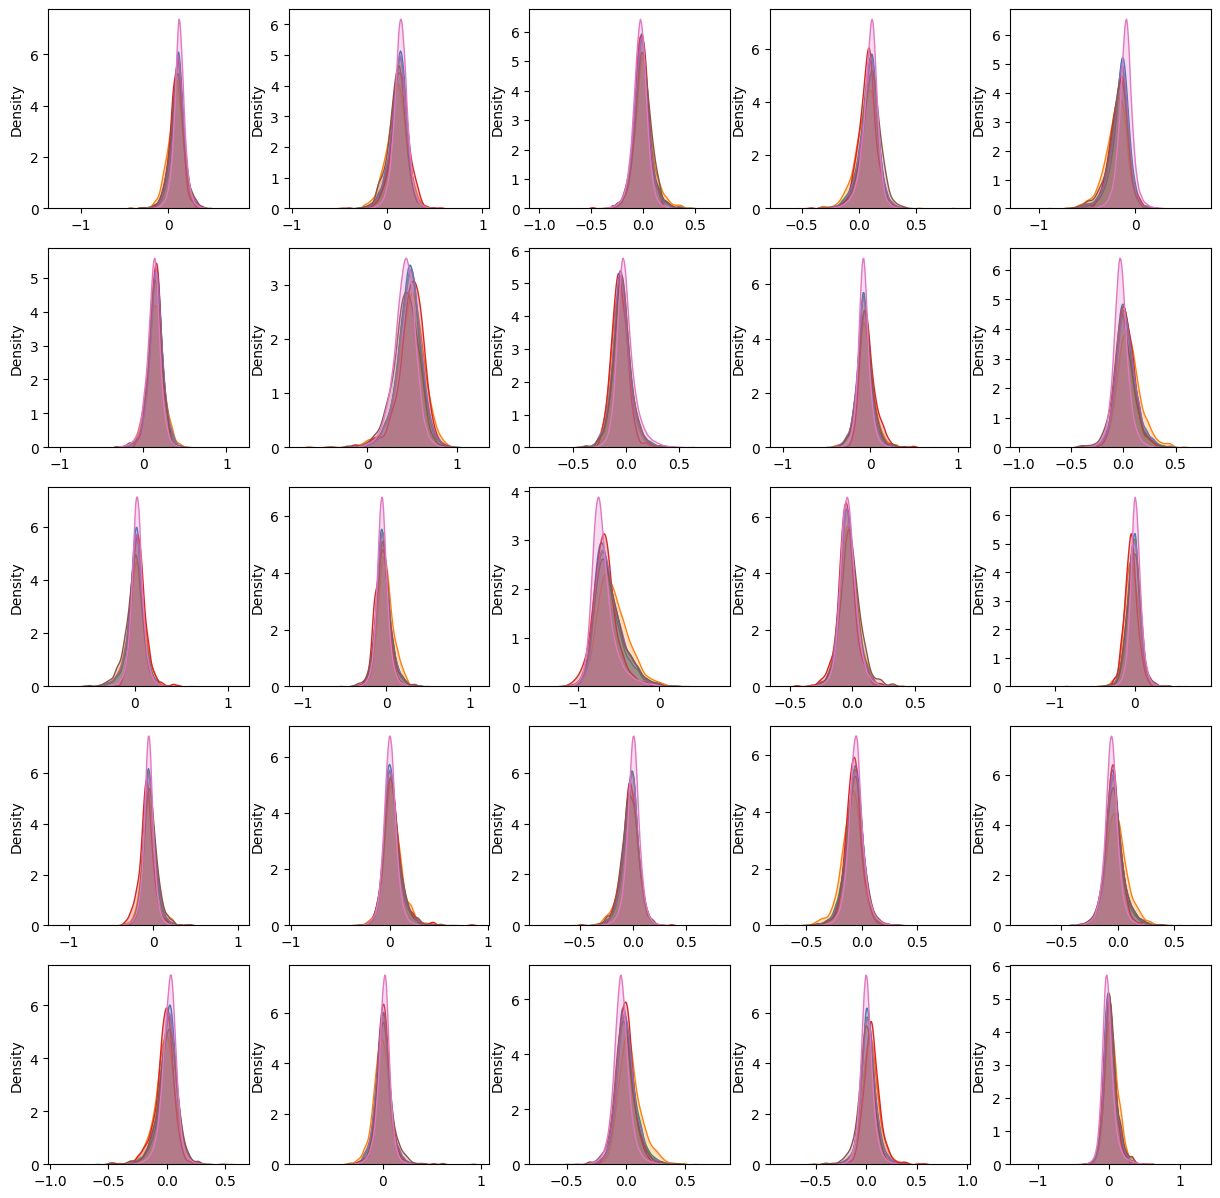

In [89]:
# plot the result of embeddings
fig, axes = plt.subplots(nrows = 5, ncols=5, figsize=(15,15))
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for dim in range(25):
    for label in labels:
        idx = processed_df[processed_df[label]==1].index.values
        li = list(map(lambda x: embeddings_glove[x][dim], idx))
        sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])
    idx = processed_df[processed_df[labels].sum(axis=1)==0].index.values
    li = list(map(lambda x: embeddings_glove[x][dim], idx))
    sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])

The difference among different labels is not very obvious.

In [ ]:
pd.DataFrame(embeddings_glove).to_csv('embeddings_glove.csv', index=False)

### FastText

Using FastText, each word, w, is represented as a bag of character n-gram. For example, given the word "introduce" and n = 3, FastText will produce the following representation composed of character tri-grams: < in, int, ntr, tro, rod, odu, duc, uce, ce > Note that the sequence, corresponding to the word here is different from the tri-gram "int" from the word introduce. Again, FastText is pre-trained on huge corpus (https://fasttext.cc/docs/en/english-vectors.html).

Advantages:
- Works for rare words, if their character n-grams which are still shared with other words
- Solves out of vocabulary words with n-gram in character level

Limitations:
- It cannot capture the meaning of the word from the text (fails to capture polysemy)

In [ ]:
# build a FastText model
start_time3 = time.time()
fasttext_path = "D:/GoogleDownloads/BT4222/crawl-300d-2M-subword/crawl-300d-2M-subword.vec"
fasttext_model = gensim.models.KeyedVectors.load_word2vec_format(fasttext_path, binary=False, limit=30000000000) # load 30B most common words
print("--- %s seconds ---" % (time.time() - start_time3))

In [ ]:
# generate embedding vectors of size 25 using tokenized text (stop words and punctuation kept)
embeddings_fasttext = processed_df["text_tokenized"].map(lambda x: get_embeddings(fasttext_model, x))

In [ ]:
# plot the result of embeddings
fig, axes = plt.subplots(nrows = 5, ncols=5, figsize=(15,15))
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for dim in range(25):
    for label in labels:
        idx = processed_df[processed_df[label]==1].index.values
        li = list(map(lambda x: embeddings_fasttext[x][dim], idx))
        sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])
    idx = processed_df[processed_df[labels].sum(axis=1)==0].index.values
    li = list(map(lambda x: embeddings_fasttext[x][dim], idx))
    sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])

Difference in distribution among different labels is very slight.

In [ ]:
pd.DataFrame(embeddings_fasttext).to_csv('embeddings_fasttext.csv', index=False)

### Bidirectional Encoder Representations from Transformers (BERT)

While each word has a fixed representation under forementioned models regardless of the context within which the word appears, BERT produces word representations that are dynamically informed by the words around them. We use the BERT base model to create sentence embeddings.

Advantages:
-  It captures the meaning of the word from the text (incorporates context, handling polysemy)

Limitations:
- Computationally expensive
- It cannot capture out-of-vocabulary words from a corpus

In [ ]:
# define a helper function to calculate the embedding vector of each text
def get_BERT_embeddings(text, max_len=512): # BERT can only take up to 512 tokens
    # tokenize sentence with BERT tokenizer
    tokenized_text = tokenizer.tokenize(text)
    tokenized_text = tokenized_text[:max_len-2] # truncate overlength text
    # add special tokens
    tokenized_text = ["[CLS]"] + tokenized_text + ["[SEP]"]
    # map the token strings to their vocabulary indeces
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    # create segment ID
    segments_ids = [1] * len(tokenized_text)
    # convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    # fead the inputs into BERT model
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]
    # use the average of the second last hidden layer of each token as sentence embedding
    token_vecs = hidden_states[-2][0]
    sentence_embedding = torch.mean(token_vecs, dim=0).numpy()
    return sentence_embedding

In [ ]:
# load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True)# whether the model returns all hidden-states
# put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

In [ ]:
# prepare the input used for BERT model
sentence_tokenized = processed_df['text_tokenized'].map(lambda x: ' '.join(x))

In [ ]:
# generate embedding vectors (stop words and punctuation kept)
start_time4 = time.time()
embeddings_bert = sentence_tokenized.map(get_BERT_embeddings)
print("--- %s seconds ---" % (time.time() - start_time4))

In [ ]:
# plot the result of embeddings
fig, axes = plt.subplots(nrows = 5, ncols=5, figsize=(15,15))
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for dim in range(25):
    for label in labels:
        idx = processed_df[processed_df[label]==1].index.values
        li = list(map(lambda x: embeddings_bert[x][dim], idx))
        sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])
    idx = processed_df[processed_df[labels].sum(axis=1)==0].index.values
    li = list(map(lambda x: embeddings_bert[x][dim], idx))
    sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])

In [ ]:
pd.DataFrame(embeddings_bert).to_csv('embeddings_bert.csv', index=False)

## Sentence Embedding

A simple and straightforward baseline method for creating sentence vectors is to use a word embedding model to encode all the words of a given sentence and take the average of all the resulting vectors. While this provides a strong baseline, it falls short of capturing information related to word order and other aspects of overall sentence semantics. Therefore, we would like to try out a few sentence embedding methods to capture a range of semantic relationships between sentences.

In [2]:
import torch
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer

In [3]:
# prevent lists from being converted to strings
processed_df = pd.read_csv('Data/processed_train.csv', 
                           converters={'text_tokenized': literal_eval, 'POS_tagging_flat': literal_eval, 'lemmatization': literal_eval})
processed_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_tokenized,POS_tagging_flat,lemmatization
0,0000997932d777bf,0,0,0,0,0,0,"[explanation, why, the, edits, made, under, my...","[(explanation, NN), (why, WRB), (the, DT), (ed...","[explanation, edits, made, username, hardcore,..."
1,000103f0d9cfb60f,0,0,0,0,0,0,"[d'aww, !, he, matches, this, background, colo...","[(d'aww, NN), (!, .), (he, PRP), (matches, VBZ...","[d'aww, match, colour, i, am, seemingly, stuck..."
2,000113f07ec002fd,0,0,0,0,0,0,"[hey, man, ,, i, am, really, not, trying, to, ...","[(hey, NN), (man, NN), (,, ,), (i, JJ), (am, V...","[hey, man, i, am, really, not, trying, edit, w..."
3,0001b41b1c6bb37e,0,0,0,0,0,0,"["", more, i, cannot, make, any, real, suggesti...","[("", IN), (more, JJR), (i, JJ), (cannot, NNS),...","[more, i, cannot, make, real, suggestion, impr..."
4,0001d958c54c6e35,0,0,0,0,0,0,"[you, ,, sir, ,, are, my, hero, ., any, chance...","[(you, PRP), (,, ,), (sir, VB), (,, ,), (are, ...","[sir, are, hero, chance, remember, page, is]"


### SentenceBERT

SentenceBERT is one of the most popular packages for generating sentence embeddings based on transformer models such as BERT, RoBERTa, and DistilBERT (https://www.kdnuggets.com/2019/09/bert-roberta-distilbert-xlnet-one-use.html). We use roberta-base-nli-mean-tokens as the pre-trained model as it improves the performance of base BERT and is optimized for NLI tasks. (https://www.sbert.net/index.html)

In [63]:
# load pre-trained model tokenizer (vocabulary)
sbert_model = SentenceTransformer('roberta-base-nli-mean-tokens')

In [51]:
# prepare the input used for BERT model
sentence_tokenized = processed_df['text_tokenized'].map(lambda x: ' '.join(x))

In [112]:
# generate embedding vectors (stop words and punctuation kept)
start_time5 = time.time()
embeddings_sbert = []
# embed batch by batch
for i in range(10000, len(sentence_tokenized), 10000):
    text = sentence_tokenized[i-10000:i].values
    embedded_text = sbert_model.encode(text)
    embeddings_sbert = np.concatenate((embeddings_sbert, embedded_text)) if len(embeddings_sbert)!=0 else embedded_text
    print(f'The first {i} texts have been embedded')
# embed the last batch of text
text = sentence_tokenized[i:len(sentence_tokenized)].values
embedded_text = sbert_model.encode(text)
embeddings_sbert = np.concatenate((embeddings_sbert, embedded_text))
print("--- %s seconds ---" % (time.time() - start_time5))

The first 10000 texts have been embedded
The first 20000 texts have been embedded
The first 30000 texts have been embedded
The first 40000 texts have been embedded
The first 50000 texts have been embedded
The first 60000 texts have been embedded
The first 70000 texts have been embedded
The first 80000 texts have been embedded
The first 90000 texts have been embedded
The first 100000 texts have been embedded
The first 110000 texts have been embedded
The first 120000 texts have been embedded
The first 130000 texts have been embedded
The first 140000 texts have been embedded
The first 150000 texts have been embedded
--- 21910.65552687645 seconds ---


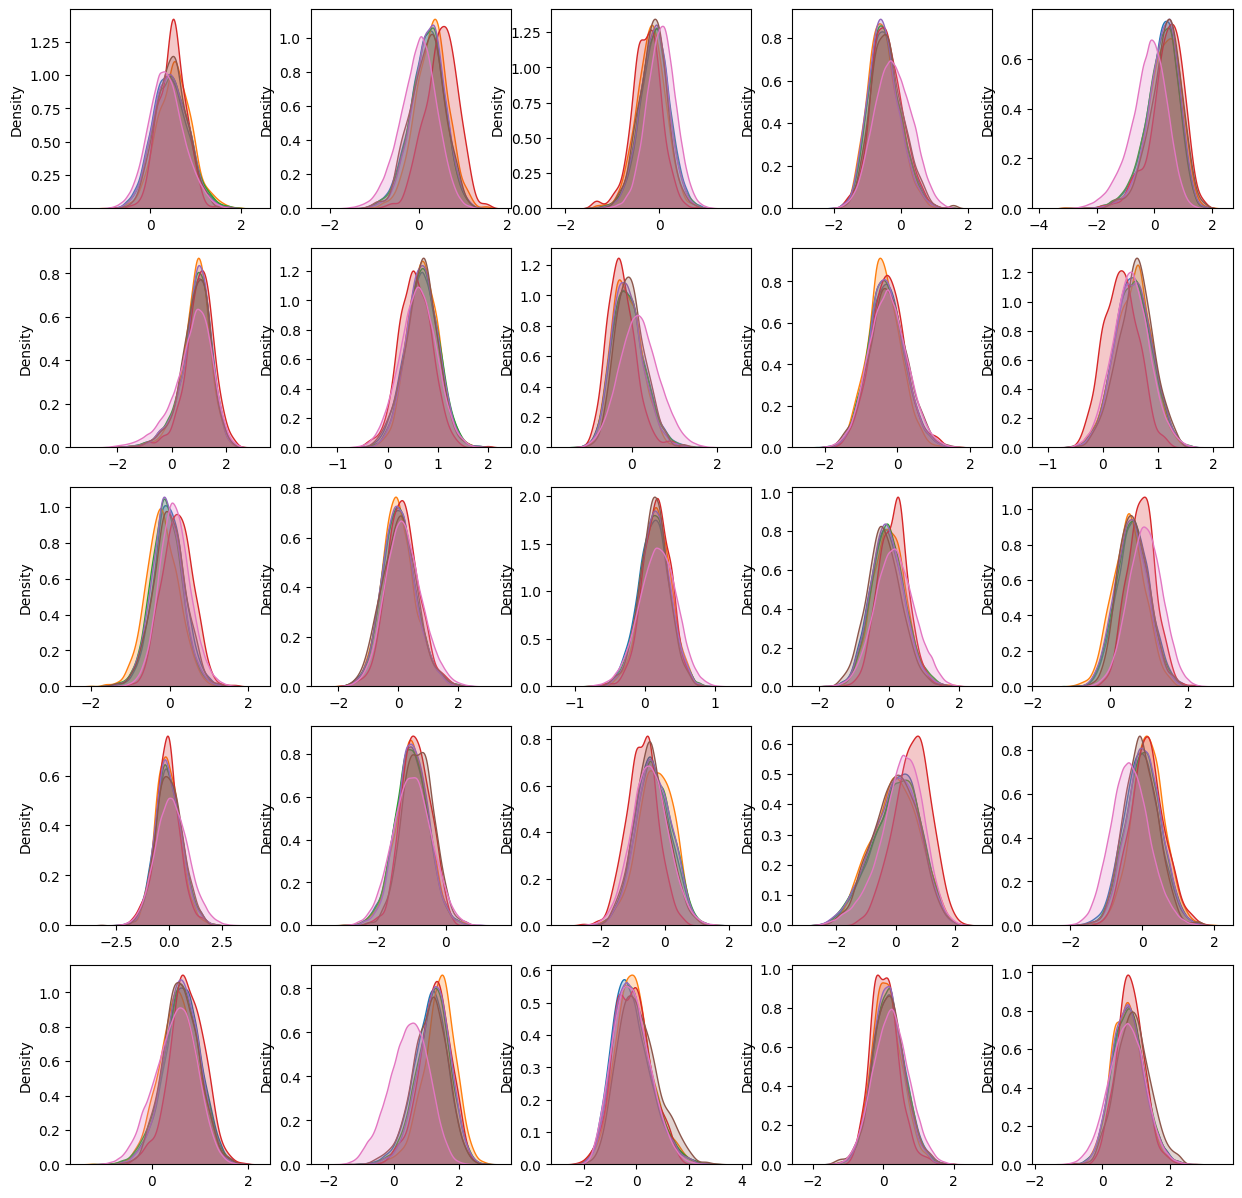

In [115]:
# plot the result of embeddings
fig, axes = plt.subplots(nrows = 5, ncols=5, figsize=(15,15))
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for dim in range(25):
    for label in labels:
        idx = processed_df[processed_df[label]==1].index.values
        li = list(map(lambda x: embeddings_sbert[x][dim], idx))
        sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])
    idx = processed_df[processed_df[labels].sum(axis=1)==0].index.values
    li = list(map(lambda x: embeddings_sbert[x][dim], idx))
    sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])

In [116]:
pd.DataFrame(embeddings_sbert).to_csv('embeddings_sbert.csv', index=False)

### BERTweet

BERTweet is the first public large-scale pre-trained language model for English Tweets. BERTweet has the same architecture as BERT-base, is trained using the RoBERTa pre-training procedure. Experiments show that BERTweet outperforms strong baselines RoBERTa-base and XLM-R-base, producing better performance results than the previous state-of-the-art models on three Tweet NLP tasks: Part-of-speech tagging, Named-entity recognition and text classification. (https://github.com/VinAIResearch/BERTweet)

In [4]:
# load pre-trained model (weights)
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")

# load pre-trained model tokenizer (vocabulary)
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
# prepare the input used for BERT model
sentence_tokenized = processed_df['text_tokenized'].map(lambda x: ' '.join(x))

In [8]:
# generate embedding vectors (stop words and punctuation kept)
start_time6 = time.time()
embeddings_bertweet = []
# embed batch by batch
for i in range(1000, len(sentence_tokenized), 1000):
    text = sentence_tokenized[i-1000:i].values
    tokenized_text = tokenizer.batch_encode_plus(text, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = bertweet(**tokenized_text)
        embedded_text = outputs.last_hidden_state.mean(dim=1)
        embeddings_bertweet = np.concatenate((embeddings_bertweet, embedded_text)) if len(embeddings_bertweet)!=0 else embedded_text
    #print(f'The first {i} texts have been embedded')
# embed the last batch of text
text = sentence_tokenized[i:len(sentence_tokenized)].values
tokenized_text = tokenizer.batch_encode_plus(text, padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    outputs = bertweet(**tokenized_text)
    embedded_text = outputs.last_hidden_state.mean(dim=1)
    embeddings_bertweet = np.concatenate((embeddings_bertweet, embedded_text))
print("--- %s seconds ---" % (time.time() - start_time6))

--- 35302.47935342789 seconds ---


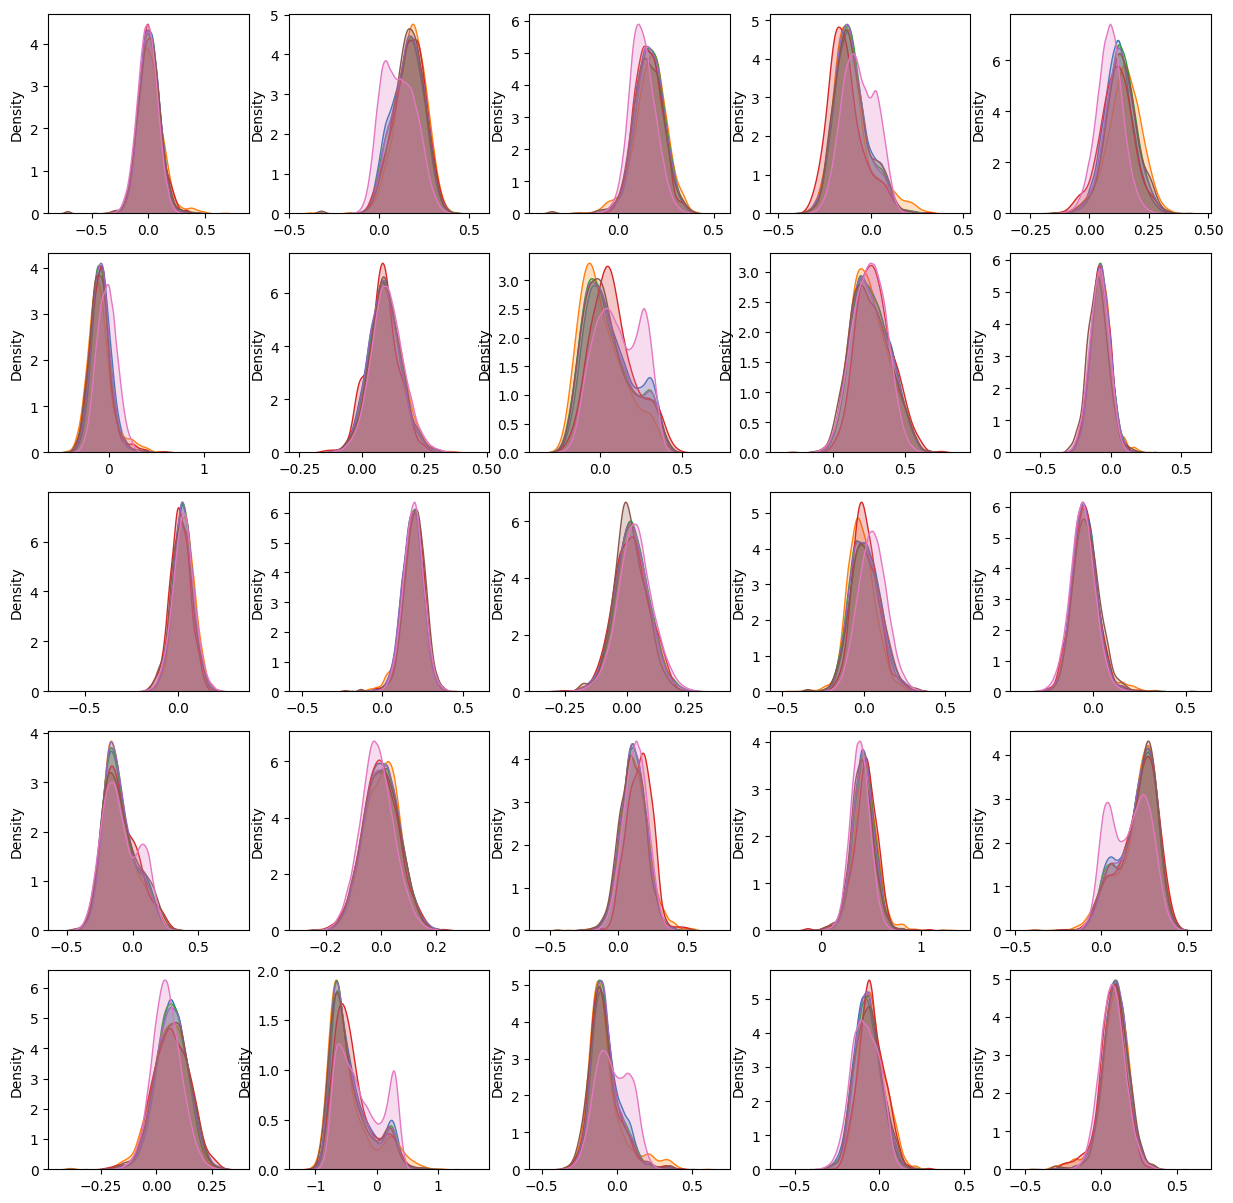

In [9]:
# plot the result of embeddings
fig, axes = plt.subplots(nrows = 5, ncols=5, figsize=(15,15))
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for dim in range(25):
    for label in labels:
        idx = processed_df[processed_df[label]==1].index.values
        li = list(map(lambda x: embeddings_bertweet[x][dim], idx))
        sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])
    idx = processed_df[processed_df[labels].sum(axis=1)==0].index.values
    li = list(map(lambda x: embeddings_bertweet[x][dim], idx))
    sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])

In [10]:
pd.DataFrame(embeddings_bertweet).to_csv('embeddings_bertweet.csv', index=False)

## Curseword Detection

Refer to https://github.com/vzhou842/profanity-check to use as an indicator for curseword

In [ ]:
featured_df['curseWord'] =  featured_df['clean_text'].apply(lambda x: predict([x])[0])

## Word Count, Text Length, Unique & Repated Words Count

In [8]:
train_df = pd.read_csv("Data/train.csv")
print(train_df.shape)
train_df.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
cleand_df_v1 = pd.read_csv('Data/noise_removed_train.csv')
cleand_df_v1.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text
0,0000997932d777bf,0,0,0,0,0,0,Explanation Why the edits made under my userna...
1,000103f0d9cfb60f,0,0,0,0,0,0,D'aww! He matches this background colour I am ...
2,000113f07ec002fd,0,0,0,0,0,0,"Hey man, I am really not trying to edit war. I..."
3,0001b41b1c6bb37e,0,0,0,0,0,0,""" More I cannot make any real suggestions on i..."
4,0001d958c54c6e35,0,0,0,0,0,0,"You, sir, are my hero. Any chance you remember..."


In [6]:
tt = TweetTokenizer()
def count(text,tt):
    text_splited = tt.tokenize(text)
    words = [word for word in text_splited if word not in string.punctuation]
    text_length = len(text)
    word_length = len(words)
    return [text_length, word_length, text_splited]

In [9]:
train_df['text_length'], train_df['words'], train_df['text_tokenized']= zip(*train_df['comment_text'].apply(
    lambda comment: count(comment,tt)))

In [10]:
clean_df = train_df.iloc[:,1:11]

In [5]:
#Without removing stopwords but punctuation

def freq(text, words, text_length):
    text = [c for c in text if c not in string.punctuation]
    if len(text) == 0:
        return [0,0,0,0,0,0,0,0]
    try:
        #get frequency vectore
        vec = CountVectorizer(ngram_range=(1, 1), stop_words=None)
        bow = vec.fit_transform([' '.join(text)])
    except:
        print(text)
        #get frequency vectore
        vec = CountVectorizer(ngram_range=(1, 1), stop_words=None)
        bow = vec.fit_transform([''.join(text)])
        print(bow)
    finally:          
        sum_of_words = bow.sum(axis=0)
        unigrams_freq = [(word, sum_of_words[0, idx]) for word, idx in vec.vocabulary_.items()]

        #how many words
        words = len(unigrams_freq)
        unigrams_freq = pd.DataFrame(unigrams_freq,columns=['word','freq'])

        #length of repeated text
        repeated_length = len(''.join(unigrams_freq['word'][unigrams_freq.freq>1]))
        #length of unique text
        unique_length = text_length-repeated_length

        #how many repeated words
        repeated_words = unigrams_freq[unigrams_freq.freq>1]
        repeated_words_length = len(unigrams_freq[unigrams_freq.freq>1])

        #how many unqiue words
        unique_words_length = words - repeated_words_length


        repeated_words_vs_length = repeated_length / text_length
        repeated_words_vs_words = repeated_words_length / words
        unique_words_vs_length = unique_length / text_length
        unique_words_vs_words = unique_words_length / words
        return [ repeated_words_length, repeated_words_vs_length, repeated_words_vs_words,
                 unique_words_length,unique_words_vs_length, unique_words_vs_words]

In [ ]:
clean_df['repeated_words_length'],\
clean_df['repeated_words_vs_length'],clean_df['repeated_words_vs_words'],\
clean_df['unique_words_length'],clean_df['unique_words_vs_length'],\
clean_df['unique_words_vs_words'] = zip(*clean_df.apply(
    lambda comment: freq(comment['text_tokenized'], comment['words'], comment['text_length']), axis=1))

['n', 'i', 'g', 'g', 'e', 'r', 'f', 'a', 'g', 'g', 'o', 't']
  (0, 0)	1
['f', 'u', 'c', 'k', 'y', 'o', 'u', 'a', 's', 'u', 'a', 'r', 'e', 'a', 'b', 'i', 't', 'c', 'h', 'a', 's', 's', 'n', 'i', 'g', 'g', 'e', 'r']
  (0, 0)	1
['P', 'E', 'N', 'I', 'S']
  (0, 0)	1
['F', 'U', 'C', 'K', 'Y', 'O', 'U']
  (0, 0)	1
['P', 'E', 'N', 'I', 'S']
  (0, 0)	1


## Stop Words

In [79]:
#stop words
eng_stopwords = set(stopwords.words("english"))

clean_df['stop_words_counts'] = cleand_df_v1['clean_text'].apply(lambda x: sum(x.count(w) for w in eng_stopwords))
clean_df['stop_words_vs_length'] = np.where(clean_df['text_length'] > 0, clean_df['stop_words_counts'] / clean_df['text_length'], 0)
clean_df['stop_words_vs_words'] = np.where(clean_df['words']  > 0, clean_df['stop_words_counts'] / clean_df['words'], 0)

## Exclamation Marks

In [80]:
# exclamation marks
clean_df['exclamation_marks_count'] = cleand_df_v1['clean_text'].apply(lambda x: x.count('!'))
clean_df['exclamation_marks_vs_length'] = np.where(clean_df['text_length'] > 0, 
                                                   clean_df['exclamation_marks_count']/clean_df['text_length'], 0)
clean_df['exclamation_marks_vs_words'] = np.where(clean_df['words']  > 0, 
                                                  clean_df['exclamation_marks_count']/clean_df['words'], 0)

## Nouns, Verbs, Adjectives

In [85]:
from nltk.tag import pos_tag

In [86]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_length,words,text_tokenized
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,45,"[Explanation, Why, the, edits, made, under, my..."
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,17,"[D'aww, !, He, matches, this, background, colo..."
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,42,"[Hey, man, ,, I'm, really, not, trying, to, ed..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,111,"["", More, I, can't, make, any, real, suggestio..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,13,"[You, ,, sir, ,, are, my, hero, ., Any, chance..."


In [90]:
pos_analysis_df = clean_df

def tag_part_of_speech(text):
    #text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text]
    text_splited = [s for s in text_splited if s]
    pos_list = pos_tag(text_splited)
    noun_count = len([w for w in pos_list if w[1] in ('NN','NNP','NNPS','NNS')])
    adjective_count = len([w for w in pos_list if w[1] in ('JJ','JJR','JJS')])
    verb_count = len([w for w in pos_list if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])
    return[noun_count, adjective_count, verb_count]


pos_analysis_df['nouns'], pos_analysis_df['adjectives'], pos_analysis_df['verbs'] = zip(*pos_analysis_df['text_tokenized'].apply(
    lambda comment: tag_part_of_speech(comment)))


In [91]:
pos_analysis_df['nouns_vs_length'] = pos_analysis_df['nouns'] / pos_analysis_df['text_length']
pos_analysis_df['adjectives_vs_length'] = pos_analysis_df['adjectives'] / pos_analysis_df['text_length']
pos_analysis_df['verbs_vs_length'] = pos_analysis_df['verbs'] / pos_analysis_df['text_length']
pos_analysis_df['nouns_vs_words'] = pos_analysis_df['nouns'] / pos_analysis_df['words']
pos_analysis_df['adjectives_vs_words'] = pos_analysis_df['adjectives'] / pos_analysis_df['words']
pos_analysis_df['verbs_vs_words'] = pos_analysis_df['verbs'] / pos_analysis_df['words']

In [93]:
pos_analysis_df.columns

Index(['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate', 'text_length', 'words', 'text_tokenized',
       'repeated_words_length', 'repeated_words_vs_length',
       'repeated_words_vs_words', 'unique_words_length',
       'unique_words_vs_length', 'unique_words_vs_words', 'stop_words_counts',
       'stop_words_vs_length', 'stop_words_vs_words',
       'exclamation_marks_count', 'exclamation_marks_vs_length',
       'exclamation_marks_vs_words', 'none', 'nouns', 'adjectives', 'verbs',
       'nouns_vs_length', 'adjectives_vs_length', 'verbs_vs_length',
       'nouns_vs_words', 'adjectives_vs_words', 'verbs_vs_words'],
      dtype='object')

## Question marks, exclamation marks & Punctuation

In [95]:
punc_analysis_df = clean_df

In [96]:
# import string library function 
def get_punctuations(sentences):
    puncs = []
    for i in sentences:
      
    # checking whether the char is punctuation.
        if i in string.punctuation:
            puncs.append(i)
        # Printing the punctuation values 
    return puncs

In [97]:
# punctuations
punc_analysis_df['punctuations'] = punc_analysis_df ['comment_text'].apply(get_punctuations)
punc_analysis_df['len_punctuations'] = punc_analysis_df['punctuations'].apply(len)
punc_analysis_df['punctuation_vs_length'] = punc_analysis_df['len_punctuations']/punc_analysis_df['text_length']
punc_analysis_df['punctuation_vs_words'] = punc_analysis_df['len_punctuations']/punc_analysis_df['words']

# question marks
punc_analysis_df['num_question_marks'] = punc_analysis_df['punctuations'].apply(lambda x:x.count('?'))
punc_analysis_df['question_marks_vs_length'] = punc_analysis_df['num_question_marks']/punc_analysis_df['text_length']
punc_analysis_df['question_marks_vs_words'] = punc_analysis_df['num_question_marks']/punc_analysis_df['words']
# exclamation marks
punc_analysis_df['num_exclamation_marks'] = punc_analysis_df['punctuations'].apply(lambda x:x.count('!'))
punc_analysis_df['exclamation_marks_vs_length'] = punc_analysis_df['num_exclamation_marks']/punc_analysis_df['text_length']
punc_analysis_df['exclamation_marks_vs_words'] = punc_analysis_df['num_exclamation_marks']/punc_analysis_df['words']

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_length,words,text_tokenized,...,adjectives_vs_words,verbs_vs_words,punctuations,len_punctuations,punctuation_vs_length,punctuation_vs_words,num_question_marks,question_marks_vs_length,question_marks_vs_words,num_exclamation_marks
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,45,"[Explanation, Why, the, edits, made, under, my...",...,0.044444,0.177778,"[?, ', ,, ., ', ', ., ., ., .]",10,0.037879,0.222222,1,0.003788,0.022222,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,17,"[D'aww, !, He, matches, this, background, colo...",...,0.000000,0.176471,"[', !, ', ., ., (, ), :, ,, ,, (, )]",12,0.107143,0.705882,0,0.000000,0.000000,1
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,42,"[Hey, man, ,, I'm, really, not, trying, to, ed...",...,0.047619,0.166667,"[,, ', ., ', ., .]",6,0.025751,0.142857,0,0.000000,0.000000,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,111,"["", More, I, can't, make, any, real, suggestio...",...,0.045045,0.216216,"["", ', -, ,, "", "", "", "", -, ., ,, -, -, ., ., ...",21,0.033762,0.189189,0,0.000000,0.000000,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,13,"[You, ,, sir, ,, are, my, hero, ., Any, chance...",...,0.000000,0.230769,"[,, ,, ., ', ?]",5,0.074627,0.384615,1,0.014925,0.076923,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,295,46,"["", ::, :, And, for, the, second, time, of, as...",...,0.108696,0.217391,"["", :, :, :, :, :, ,, ,, ?, ', -, ,, "", "", "", ...",18,0.061017,0.391304,2,0.006780,0.043478,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,99,19,"[You, should, be, ashamed, of, yourself, That,...",...,0.052632,0.210526,"[., ., ., .]",4,0.040404,0.210526,0,0.000000,0.000000,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,81,11,"[Spitzer, Umm, ,, theres, no, actual, article,...",...,0.090909,0.181818,"[,, ., -, .]",4,0.049383,0.363636,0,0.000000,0.000000,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0,116,25,"[And, it, looks, like, it, was, actually, you,...",...,0.040000,0.240000,[.],1,0.008621,0.040000,0,0.000000,0.000000,0


## Upper case & Lower case

In [99]:
def uppercase_lowercase(text, text_tokenized):
    uppercase_length = sum(1 for c in text if c.isupper())
    uppercase_words_length = sum(1 for word in text_tokenized if word.isupper())
    
    lowercase_length = sum(1 for c in text if c.islower())
    lowercase_words_length = sum(1 for word in text_tokenized if word.islower())
    
    return [uppercase_length, uppercase_words_length, lowercase_length, lowercase_words_length]
       

In [100]:
clean_df['uppercase_length'],\
clean_df['uppercase_words_length'],\
clean_df['lowercase_length'],\
clean_df['lowercase_words_length'] = zip(*clean_df.apply(
    lambda comment: uppercase_lowercase(comment['comment_text'], comment['text_tokenized']), axis=1))

In [102]:
clean_df['uppercase_vs_length'] = clean_df['uppercase_length'] / clean_df['text_length']
clean_df['uppercase_vs_words'] = clean_df['uppercase_words_length'] / clean_df['words']
clean_df['lowercase_vs_length'] = clean_df['lowercase_length'] / clean_df['text_length']
clean_df['lowercase_vs_words'] = clean_df['lowercase_words_length'] / clean_df['words']

## Timestamp and time

In [103]:
def count_regexp_occ(regexp="", text=None):
    """ Simple way to get the number of occurence of a regex"""
    return len(re.findall(regexp, text))

In [128]:
# Check for time stamp
clean_df["has_timestamp"] = clean_df["comment_text"].apply(lambda x: count_regexp_occ(r"\d{2}|:\d{2}", x))
# Check for dates 18:44, 8 December 2010
clean_df["has_date_long"] = clean_df["comment_text"].apply(lambda x: count_regexp_occ(r"\D\d{2}:\d{2}, \d{1,2} \w+ \d{4}", x))
# Check for date short 8 December 2010
clean_df["has_date_short"] = clean_df["comment_text"].apply(lambda x: count_regexp_occ(r"\D\d{1,2} \w+ \d{4}", x))


## http & mail

In [129]:
# Check for http links
clean_df["has_http"] = clean_df["comment_text"].apply(lambda x: count_regexp_occ(r"http[s]{0,1}://\S+", x))
# check for mail
clean_df["has_mail"] = clean_df["comment_text"].apply(
    lambda x: count_regexp_occ(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', x)
)

## IP address

In [130]:
clean_df["has_ip_address"] = clean_df["comment_text"].apply(
    lambda x: count_regexp_occ(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', x)
)

## Readability

Refer to :https://datascience103579984.wordpress.com/2020/01/19/feature-engineering-for-nlp-in-python-from-datacamp/
Flesch is being used widely and mostly. Higher the score, the greater readability -> easy to read

In [227]:
from textatistic import Textatistic

In [252]:
def readability(text):
    try:
        score = Textatistic(' '.join(text)).flesch_score
        return score
    except:
        return np.nan

In [253]:
clean_df["readability"] = clean_df["text_tokenized"].apply(
    lambda x: readability(x)
)

## Selection

In [256]:
clean_df.columns

Index(['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate', 'text_length', 'words', 'text_tokenized',
       'repeated_words_length', 'repeated_words_vs_length',
       'repeated_words_vs_words', 'unique_words_length',
       'unique_words_vs_length', 'unique_words_vs_words', 'stop_words_counts',
       'stop_words_vs_length', 'stop_words_vs_words',
       'exclamation_marks_count', 'exclamation_marks_vs_length',
       'exclamation_marks_vs_words', 'none', 'nouns', 'adjectives', 'verbs',
       'nouns_vs_length', 'adjectives_vs_length', 'verbs_vs_length',
       'nouns_vs_words', 'adjectives_vs_words', 'verbs_vs_words',
       'punctuations', 'len_punctuations', 'punctuation_vs_length',
       'punctuation_vs_words', 'num_question_marks',
       'question_marks_vs_length', 'question_marks_vs_words',
       'num_exclamation_marks', 'uppercase_length', 'uppercase_words_length',
       'lowercase_length', 'lowercase_words_length', 'uppercase_vs_

In [266]:
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
features = ('text_length', 'words','repeated_words_length', 'repeated_words_vs_length',
       'repeated_words_vs_words', 'unique_words_length',
       'unique_words_vs_length', 'unique_words_vs_words', 'stop_words_counts',
       'stop_words_vs_length', 'stop_words_vs_words',
       'exclamation_marks_count', 'exclamation_marks_vs_length',
       'exclamation_marks_vs_words', 'nouns', 'adjectives', 'verbs',
       'nouns_vs_length', 'adjectives_vs_length', 'verbs_vs_length',
       'nouns_vs_words', 'adjectives_vs_words', 'verbs_vs_words',
        'len_punctuations', 'punctuation_vs_length',
       'punctuation_vs_words', 'num_question_marks',
       'question_marks_vs_length', 'question_marks_vs_words',
       'num_exclamation_marks', 'uppercase_length', 'uppercase_words_length',
       'lowercase_length', 'lowercase_words_length', 'uppercase_vs_length',
       'uppercase_vs_words', 'lowercase_vs_length', 'lowercase_vs_words',
       'has_timestamp', 'has_date_long', 'has_date_short', 'has_http',
       'has_mail', 'has_ip_address', 'readability'
           )
clean_df['none'] = 1 - clean_df[LABELS].max(axis=1)

In [267]:
columns = LABELS + ['none']
rows = [{c:clean_df[f].corr(clean_df[c]) for c in columns} for f in features]
train_correlations = pd.DataFrame(rows, index=features)

<AxesSubplot: >

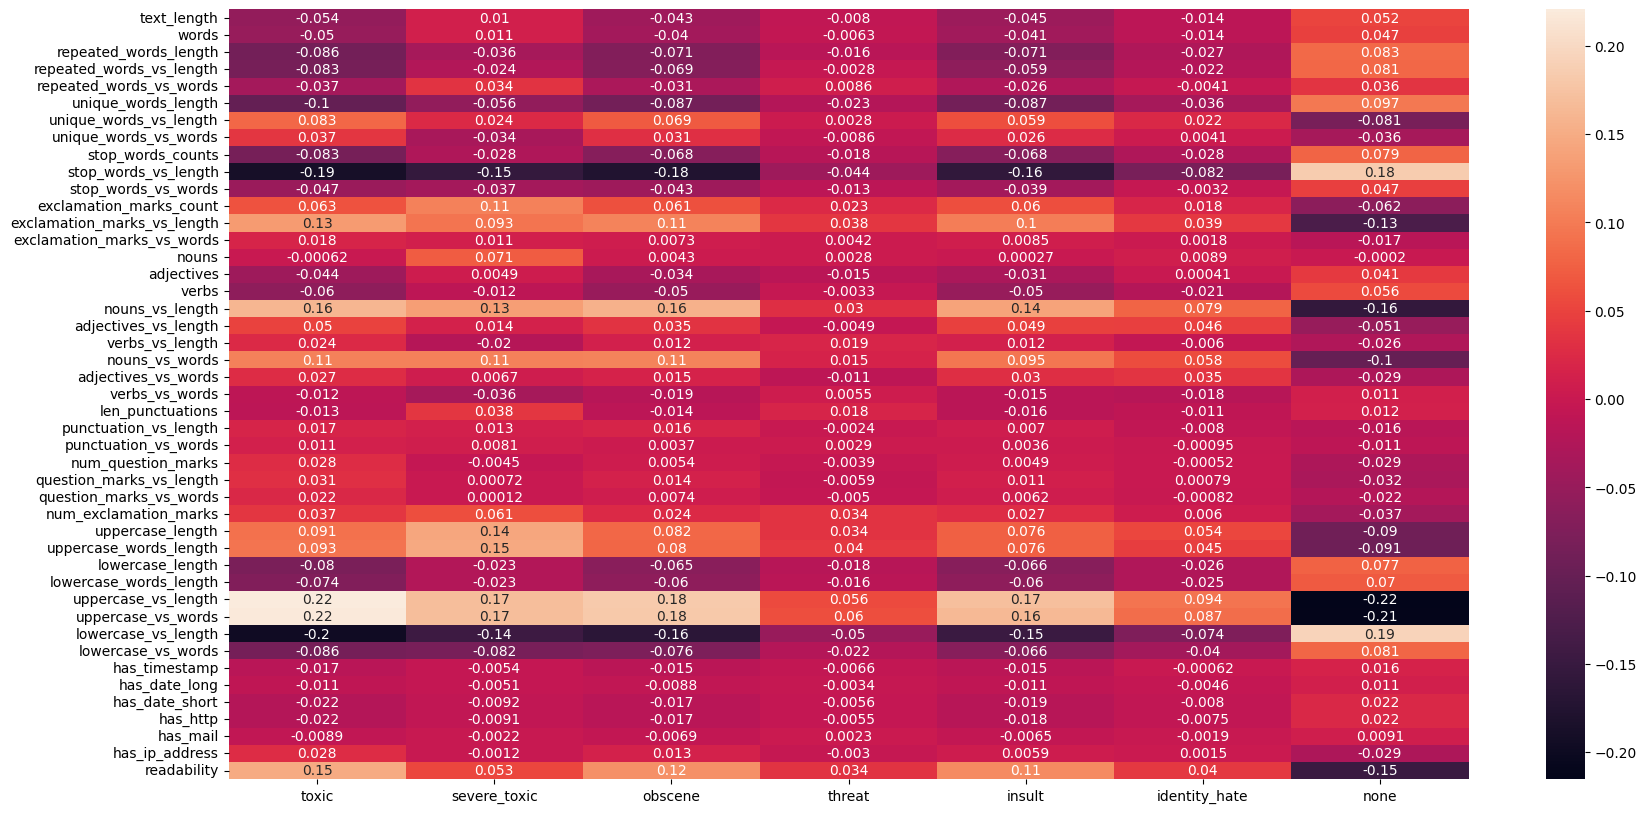

In [269]:
plt.figure(figsize = (20,10))
sns.heatmap(train_correlations, annot=True)